In [1]:
from pybatteryid import ModelStructure
from pybatteryid.model import save_to_file, print_model_details
from pybatteryid.plotter import plot_time_vs_current

from data import helper

### Example 3 - Model Identification for an LFP Battery

This file contains an example to identify battery models for a 3.5 Ah LFP battery. In this case, a second model input has been introduced representing the maximum hysteresis overpotential. Furthermore, appropriate basis functions corresponding to the second input have also been included. See [X] for more details.

#### A. Initialize model structure

In [2]:
# The LFP battery being modelled has the capacity around
# 3.5 Ah. The exact value has been calculated by
# coulomb counting during quasi-OCV experiment.
battery_capacity = 13270.180265768407
# The experimental measurements were recorded with 1s
# sampling period.
sampling_period = 1

model_structure = ModelStructure(battery_capacity=battery_capacity, sampling_period=sampling_period)

#### B. Load EMF and Hysteresis data

In [3]:
#
emf_data = helper.load_npy_data('data/lfp/quasi_emf.npy')
model_structure.add_emf_function(emf_data['soc_values'], emf_data['voltage_values'])
# 
hysteresis_data = helper.load_npy_data('data/lfp/hysteresis_data.npy')
model_structure.add_hysteresis_function(hysteresis_data['soc_values'], hysteresis_data['voltage_values'])

#### C. Add Basis Functions

In [4]:
model_structure.add_basis_functions(
    [ 's⁻¹', 'log[s]', 's', 'exp[0.02sqrt[|i|]]', 'd[0.01,0.99]' ],
    [ 'd[0.900,1]', 'd[0.995,1.0]', 'd[0.999,1]' ]
)

#### D. Identify a battery model

We identify a battery model for given model order $n$ and nonlinearity order $l$.

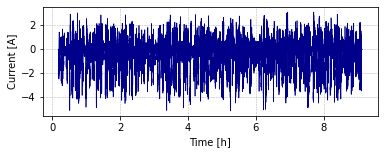

In [7]:
# 
dataset = helper.load_npy_data(f'data/lfp/identification_data_first.npy')
#
plot_time_vs_current([(dataset['time'] / 3600, dataset['current'])],
                     units=('h', 'A'), colors=['darkblue'])

In [11]:
model = model_structure.identify(
    dataset, initial_soc=0.985, model_order=1, nonlinearity_order=1, optimizers=['lasso', 'ridge']
)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing LASSO using `l1regls.py` from cvxopt.org. See the following link for details:                        │
│ https://cvxopt.org/examples/mlbook/l1regls.html                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

     pcost       dcost       gap    pres   dres
 0: -1.7358e+02 -1.6204e+02  3e+01  1e+01  8e-10
 1: -1.6261e+02 -1.6183e+02  2e+00  8e-01  5e-11
 2: -1.6168e+02 -1.6163e+02  2e-01  7e-02  5e-12
 3: -1.6159e+02 -1.6159e+02  4e-02  1e-02  7e-13
 4: -1.6158e+02 -1.6158e+02  5e-03  1e-03  7e-14
 5: -1.6158e+02 -1.6158e+02  5e-04  6e-05  2e-14
 6: -1.6158e+02 -1.6158e+02  6e-06  7e-07  2e-14
 7: -1.6158e+02 -1.6158e+02  6e-08  7e-09  6e-15
Optimal solution found.


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing cross-validated Ridge regression using `sklearn` package.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Solution found using alpha = 0.1

#### E. Print Model Details

In [12]:
#
print_model_details(model)

          Model order = 1; Nonlinearity order = 1           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Term                     ┃ Estimated Parameter     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ v(k-1)                         │ 0.44330798945249134     │
│ v(k-1)*s⁻¹(k-1)                │ 0.0005494603090170399   │
│ v(k-1)*log[s](k-1)             │ -0.020974207317337398   │
│ v(k-1)*exp[0.02sqrt[|i|]](k-1) │ 0.4399224365756567      │
│ i(k)                           │ 0.0037630659307536546   │
│ i(k)*s⁻¹(k)                    │ 9.079733902289128e-05   │
│ i(k)*log[s](k)                 │ -0.0006397440481999759  │
│ i(k)*exp[0.02sqrt[|i|]](k)     │ 0.01741351840071551     │
│ i(k)*d[0.01,0.99](k)           │ 0.00031327871424417027  │
│ i(k-1)*s⁻¹(k-1)                │ -4.8869373289536464e-05 │
│ i(k-1)*log[s](k-1)             │ 0.0011926249836558573   │
│ i(k-1)*exp[0.02sqrt[|i|]](k-1) │ -0.01751283671563306    │
│ i(k-1)*d[0.01,0.99](k-1)       │ -4.077857350304169e-05  │
│ h(k)                           │ -0.08759269086715858    │
└────────────────────────────────┴─────────────────────────┘

#### F. Save Model to File

In [13]:
save_to_file(model, 'results/lfp', 'model_one')